In [2]:
import os
import xml.etree.ElementTree as ET
import logging
import sys
import time
import copy
import warnings
from functools import reduce
import datetime

import stanfordnlp
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import numpy as np
import torch as th

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import train_reviews_path, test_reviews_path, TEST_APPENDIX, word2vec_model_path, UNKNOWN_WORD, parsed_reviews_dump_path
from src.review import get_reviews, load_reviews, dump_reviews, reviews_dump_path
from src.preprocess.spell_check import spell_check, load_checked_reviews
from src.preprocess.dep_parse import parse_reviews, load_parsed_reviews, dump_parsed_reviews
from src.polarity.classifier import PolarityClassifier
from src.utils.embedding import get_embeddings

seed = 42
np.random.seed(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
logging.basicConfig(level=logging.INFO)

In [3]:
word2vec = get_embeddings()

INFO:gensim.models.utils_any2vec:loading projection weights from /home/dmitry/Projects/diploma/research/RusVectores/tayga_upos_skipgram_300_2_2019/model.bin
INFO:gensim.models.utils_any2vec:loaded (249565, 300) matrix from /home/dmitry/Projects/diploma/research/RusVectores/tayga_upos_skipgram_300_2_2019/model.bin


In [4]:
# ___________________________Train_______________________________
train_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path)
train_sentences = [x for x in reduce(lambda x, y: x + y, train_reviews)]

INFO:root:Upload dependency trees from dump.


In [5]:
# ___________________________Test________________________________
test_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path + TEST_APPENDIX)
test_sentences = [x for x in reduce(lambda x, y: x + y, test_reviews)]

INFO:root:Upload dependency trees from dump.


/home/dmitry/Projects/diploma/research/.venv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
INFO:root:Total parameters number: 26143
INFO:root:| Epoch 00000| Train accuracy: 0.75848597| Validation accuracy: 0.66923076| Time 4.4432 sec
INFO:root:| Epoch 00001| Train accuracy: 0.75897437| Validation accuracy: 0.66923076| Time 4.6619 sec
INFO:root:| Epoch 00002| Train accuracy: 0.75897437| Validation accuracy: 0.66923076| Time 4.2949 sec
INFO:root:| Epoch 00003| Train accuracy: 0.75897437| Validation accuracy: 0.66923076| Time 4.3379 sec
INFO:root:| Epoch 00004| Train accuracy: 0.75897437| Validation accuracy: 0.66923076| Time 4.2243 sec
INFO:root:| Epoch 00005| Train accuracy: 0.75897437| Validation accuracy: 0.66923076| Time 4.2637 sec
INFO:root:| Epoch 00006| Train

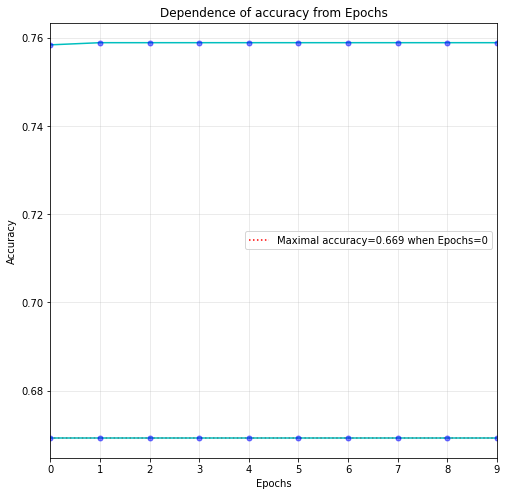

In [6]:
# preprocess_pipeline(word2vec=word2vec, is_train=True)
# preprocess_pipeline(word2vec=word2vec, is_train=False)

classifier = PolarityClassifier(word2vec=word2vec)
classifier.fit(train_sentences, test_sentences)

In [8]:
test_sentences_pred = copy.deepcopy(test_sentences)
test_sentences_pred = classifier.predict(test_sentences_pred)

In [9]:
for sentence in test_sentences_pred:
    sentence.to_sentence().get_normalized().display()

очень милый , уютный ресторанчик со скромными ценами за огромные порции вкуснейших блюд .мы отмечали день рождения , нам разрешили принести свой тортик со свечками .салаты со свежайшей зеленью , мясо и курица нежные , а десерт , в частности семифреддо миндальный - это что-то сказочно вкусное .официантки вежливые и улыбчивые .единственное , что немного не понравилось - долго ждали начала обслуживания ( видимо , из-за большого количества народа ) и с соседних столов никто не убирал посуду , когда ушли люди .но это мелочи .общее впечатление прекрасное .советуем !отличный ресторан , была здесь уже не раз и вот решилась отпраздновать свой день рождения .и я , и все гости остались очень довольны .кухня на уровне , все свежее , вкусное и аутентичное )особенно хочется отметить спиртные напитки - вино просто великолепное , коктейли бесподобны .порадовали музыканты - играли душевно , так что мы не упустили возможности потанцевать .счет за все это великолепие оказался совсем небольшим - особенно 

советы по проведению банкета .встреча друзей ( нас было восемь человек ) прошла великолепно - все остались очень довольны .и прекрасный отдельный зал ( см . - фото галерею ) , и внимательный , но ненавязчивый персонал , и оригинальная кухня ( мы взяли 8 разных горячих блюд и каждый утверждал , что у него самое вкусное ) - все было просто " супер " .большое спасибо за прекрасный вечер , обязательно придем еще раз .p . s . кстати : прекрасный сайт ресторана , меню ! фото .наш свадебный банкет состоялся 10 июля .хотим выразить огромную благодарность персоналу и отдельно администратору елене за прекрасное обслуживание .ресторан выбирали долго , ни разу не пожалели о своем выборе .из плюсов назову замечательное расположение ресторана ( если среди гостей есть приезжие из других городов , это особенно важно ) .понравилась сама еда , повар - чудо ! мы выбрали меню за 1500 на человека , заказали блюдо от - шеф повара и еще один салат , но и без наших дополнений угощения было бы достаточно .в ре

семейная .персонал внимательный , обслуживание супер !учитывают все пожелания !готовят замечательно !очень вкусные блюда , всё качественное , отлично готовят мясо !ресторан оставил великолепное впечатление !были в ресторане 26 апреля .обстановка весьма уютная .публика мне там понравилось .и иностранцы и студенты сидели .разные люди . и всем был обеспечен хороший прием .из меню все вкусно и звучит и выглядит .когда попробовали сами убедились .ели хачапури . сыр сулугуни , свинину и салат из морепродуктов .все вкусно .больше понравился хачапури с сыром .то ли о того , что голодная была , то ли от того , что правда вкусно … .запивали грузинским вином .тоже весьма неплохое .средний счет оказался весьма приличным . но только сугубо из-за вина .считаю место достойное и недорогое .играет фоновая музыка .персонал вежливый и приветливый .атмосфера романтическая .готовят хорошо .согласна с предыдущими отзывами : столики слишком близко друг от друга .для ресторана при гостинице я считаю , что он 

.присоединяюсь к положительным отзывам .это , конечно , не ресторан в полном смысле этого слова , но отличное кафе с вкусной кухней и умеренными ценами .порции большие , первый раз взяли как полагается : салат , первое . второе и компот - еле выползли из-за стола .большой выбор вторых блюд , вкусные супы , выпечка тоже понравилась .интерьер вполне соответствует статусу , единственный минус - действительно , непонятно какой из залов для некурящих , то ли везде курят , то ли вытяжка плохо работает .в общем , повадились мы туда ходить обедать раз в неделю , когда по работе бываем в тех краях .и заметили , что уже ждем с предвкушением именно этого дня !ресторанчик небольшой , по обстановке поняла , что туда ходят постоянные клиенты ) )шеф повар сделала замечательные десерты тирамису ) ) ) ) ) )советую ! все блюда подаются на больших и тяжелых тарелках необычной формы ) ) ) ) ) )этот ресторан был первым в десятке лучших японских , но суши я ела и вкусней .они конечно большие и сочные , но т

в ночные посиделки , караоке и танцы .интерьер очень нравится , только давно пора бы сделать ремонт , думаю , большинство посетителей были бы за эту идею , хотя старенький интерьер , немного обшарпанная мебель не мешают приезжать сюда вновь и вновь , ведь главное атмосфера !кухня в зималето очень неплохая : хорошее и вкусное - гриль меню ( особенно рыба ) , стандартный выбор салатиков , большой выбор суши и роллов ( самые вкусные гейша и запеченные киото ) , достойная коктейльная карта , только вот лонг , оставляет желать лучшего , а клубничную маргариту не советую никому , отвратная !но не все же должно быть идеально !курю кальян только здесь , считаю , что здесь он один из лучших в городе .единственный минус этого заведения - это обслуживание : девушки на хостес с отсутствующим взглядом , воображают себя хозяйками заведения , официантов много , а толку мало .на выходных , особенно ближе к ночи заказы приходится долго ждать , счета не дождешься , а если ещё и захочешь забрать часть сд

как он выглядит , оказывается нет .салат цезарь состоял из следующих компонентов : внизу лежали крупные 4 куска ( именно куска ) отрезанные от багета , сверху листья салата , затем немного помидор и 4 именно больших полоски курицы , пармезана не было вообще , круто ?затем принесли пиццу - наверное она была сделана из резины .стоит все это " удовольствие " недешево , сервис . да , забыла написать , что была еще живая музыка , правда музыкант откровенно фальшивил .становится страшно , что все меньше и меньше остается в питере достойных ресторанов .больше мы никогда не придем в данное заведение .в данное кафе зашли совершенно случайно , обойдя ближайшие заведения не найдя подходящего !кафе интерьера очень понравился и мы решили остаться так сказать " не заглядывая в меню " .на следующий день пришли с друзьями , они также остались в восторге !к плюсам кафе хотелось бы отнести следующее : 1 ) вкусная кухня 2 ) доступные цены 3 ) уютная обстановкак минусам : расположение ( расположено во дво

с мужем там периодически .очень ! нравятся горячие , с хрустящей корочкой булочки .в порции их 3 штуки : ржаная , пшеничная и смешанная .к ним иногда приносят сливочное масло ) ) )к тому времени , как принесут закуски , булочки со стола уже исчезают : не можем просто на них смотреть , уж очень они вкусные .прочитала отзыв про хачапури с сыром , и уже хочу попробовать , не сомневаюсь , что будет бесподобно !никогда не могу удержаться от заказа запеченных мидий в сливочном соусе , которые сервируются на большой тарелке с горкой морской соли .а также никогда не отказываюсь от шашлыка из баранины на косточке !шашлык необыкновенный , так же как и соус к нему .и что очень приятно - к шашлыку приносят тарелку с водой и лимоном для споласкивания рук : я шашлык люблю есть руками .муж обычно заказывает рыбу , от которой всегда остается в восторге !здесь вкусно !рекомендуем .интерьер особо не порадует : складывается впечатление , что задумка из - 90 х годов прошлого века . но это не мешает хорошо

( правда , приборы не раскладывают и вино не наливают ) .но кухня очень понравилась .спасибо - шеф повару !для четырех человек заказывали различные салаты и горячее .порции большие , всё вкусно приготовлено , подается - во время .рекомендую всем , кто после прогулки решил вкусно пообедать .цены очень демократичные .17 апреля посетил ваш ресторан .ещё с улицы заметил ваш замечательный интерьер и решил у вас поужинать .первое что понравилось , это то как меня встретил ваш менеджер илья , всё как я люблю , с улыбкой и юмором .после меня посадили за столик и я был приятно удивлён что официант любезно взял мою верхнюю одежду и повесил в гардероб . ( давно такого не встречал ) .так как у вас был в первый раз , очень благодарен официанту валентину за грамотное объяснение всех моих вопросов по поводу меню .и опять хочу отметить что ваш персонал очень позитивен .валентин излучал позитив и очень поднял мне настроение после моего рабочего дня . ( позитив официантов особенно в вечернее время это с

барами = )буду рекомендовать это место друзьям , сам с удовольствием еще раз приду .в субботу вечером пошли отмечать день рождение .васаби порядком надоел , хотелось что-нибудь новенькое , пошли в это заведение поскольку относительно близко к дому .еда мне понравилась , но не вся : острый суп с креветками обалденный , а вот свинина в соусе с лапшой не - очень мясо было безвкусное , тирамису - вкусный редко где его хорошо готовят .обслуживание отличное , ненавязчивые официанты , но и ждать не приходится , приветливые и отзывчивые .интерьер на любителя .место мне понравилось , но очень громко играла музыка , совершенно не было слышно что говорят , это минус , но надеюсь когда приду в следущий раз будет потише )ходили , ходим и ходить будем !давно искали - джаз клуб , в котором можно не только посидеть за барной стойкой , но и вкусно покушать за столиками и поболтать .нашли .если есть желание сесть за столик , а не у бара , то лучше бронировать заранее .вечером всегда отличная программа ,

In [7]:
for sentence in test_sentences:
    sentence.to_sentence().get_normalized().display()

очень милый , уютный ресторанчик со скромными ценами за огромные порции вкуснейших блюд .мы отмечали день рождения , нам разрешили принести свой тортик со свечками .салаты со свежайшей зеленью , мясо и курица нежные , а десерт , в частности семифреддо миндальный - это что-то сказочно вкусное .официантки вежливые и улыбчивые .единственное , что немного не понравилось - долго ждали начала обслуживания ( видимо , из-за большого количества народа ) и с соседних столов никто не убирал посуду , когда ушли люди .но это мелочи .общее впечатление прекрасное .советуем !отличный ресторан , была здесь уже не раз и вот решилась отпраздновать свой день рождения .и я , и все гости остались очень довольны .кухня на уровне , все свежее , вкусное и аутентичное )особенно хочется отметить спиртные напитки - вино просто великолепное , коктейли бесподобны .порадовали музыканты - играли душевно , так что мы не упустили возможности потанцевать .счет за все это великолепие оказался совсем небольшим - особенно 

завышены .шарлотка действительно вкусная , " домашняя " : ) ради десертов я бы пришла еще раз .ну и просто приятно - посидеть пообщаться .что еще хотелось бы отметить - касается террасы - тесновато .не очень приятно сидеть чуть ли не вплотную к другим столам и вынужденно слушать чужие разговоры .очень много мужчин , которые сидят и не стесняясь обсматривают сверху донизу , как будто для них специально и пришли выставляться .сложилось впечатление , что и мужчины , и дамы туда ходят именно искать знакомств для легкого времяпровождения .в остальном всё очень даже мило : )зашли поужинать вечером .нам предложили - vip кабинет ( см . - фото галерею ресторана ) .нам все очень понравилось : интерьер , обслуживание . кухня .настолько понравилось , что мы решили пригласить своих друзей отметить день рождения в этом ресторане .администратор виктория тут же составила меню , учла все наши пожелания , дала советы по проведению банкета .встреча друзей ( нас было восемь человек ) прошла великолепно - 

, мягкие , уютные диванчики , хорошее освещение ( не напрягает )стол заказал утром в субботу на вечер .официант посоветовал сделать предзаказ , рассказал меню , посоветовал блюда .сервировка приятная .блюда были приготовлены вкусно .горячее принесли вовремя .в общем ребятам понравилось .обслуживание отличное .нас обслуживал андрей , ему большое спасибо , не приходилось искать его и высматривать .по деньгам я был даже приятно удивлён - не так дорого .сами - посудите на 6 человек 7500р .отличное место .отличная кухня .муж работает рядом . решили зайти , отметить личный небольшой праздник .приятный - интерьер очень светло на душе и уютно .молодцы 10 ! обслуживание отличное милейшая официантка ( по-моему эльвира ) красивая девушка . внимательная . даже на мою - просьбу ножницы ( надо было отрезать кусочек пластыря ) сразу же принесли , чистые скатерти , смена приборов , очень красивая сервировка блюд .жаль нет шашлыка из - баранины но только открылись , думаю меню разрастется ! а из свинин

бокал вина ( не помню какое ) - 150 р , сигареты с зажигалкой - кэнд 100 р . , пиво ( какое-то разливное хохляцкое , вкусное однако ) 150 р . ( бутылочное по 130 ) , итого общий счет с алкоголем на троих вышел 1470 р . + чай .жалко в этом районе бываю очень редко , поэтому следующий раз зайти получится не скоро , а так периодически думаю посещал это место .29 апреля праздновали свадьбу в амулете .ресторан нас очень порадовал нас и наших гостей .все было очень здорово , еда вкусная , меню брали 1500 на человека , всем хватило , все что осталось нам упаковали .очень понравилась горячая закуска - филе цыпленка в темпуре , из горячего основного блюда хочется отметить телятину с грибным соусом - очень нежно и вкусно !обслуживание замечательное , девушки официантки молодцы после праздника помогли упаковать не только еду но и все цветы , которые нам подарили !новый зал очень красивый - светлый , много места , люстры шикарные !выражаем благодарность администратору лилиане и всему коллективу ре

мягче .суши и роллы . это отдельная тема , по мне , так лучшие в городе , никакая генза не сравнится .причем вкусные абсолютно все , самые любимые : ролл киото , ролл с острым лососем .что касается десертов , то к ним я отношусь более чем спокойно , но торт наполеон и чизкейк с филадельфией , фруктовый тартар в положительную сторону изменили мое отношение к десертам .решили отметить с женой годовщину нашей свадьбы в - шабу шабу .когда мы пришли , посетителей почти не было , и мы сели в небольшом зале .было тихо и спокойно , пока не пришла компания из 4-х человек .казалось , что они сели за наш столик , настолько мало там места .в эту комнату надо было поставить не четыре стола , а два .кухня в этом заведении нам очень понравилась .все блюда сделаны из свежайших продуктов .роллы с угрем впечатлили больше всего , в следующий раз попробуем и другие .а так же мы заказали фирменное блюдо - шабу шабу ( фондю по японски )самый вкусный ингредиент - мраморное мясо , просто пальчики оближешь .бу

доступные цены 3 ) уютная обстановкак минусам : расположение ( расположено во дворе ) , но лично меня это не сильно напрягает !встречались в этом пабе с подругой .дело было в четверг , днем .посетителей сначала было немного , но чем ближе время шло к вечеру , тем больше бар заполнялся .при этом в зале не было накурено , видать хорошая и продуманная система вентиляции .приятная , достаточно уютная атмосфера в стиле паба .очень неплохое меню , но всё весьма сытное , вкусное .и большие порции , что не может не понравиться мужчинам .моя подруга здесь бывала гораздо чаще меня , говорит , что перепробовала почти всё , и ей нравится .- - девушка официант расторопно нас обслуживала , на мой шутливый коммент про что-нибудь легкое и низкокалорийное отреагировала очень быстро и предложила несколько вариантов блюд , хотя я совсем не собиралась соблюдать строгую диету или какие-то ограничения в еде .и вообще на все вопросы отвечала сразу и исчерпывающе , что очень приятно .может и не всегда молниен

баранины на косточке !шашлык необыкновенный , так же как и соус к нему .и что очень приятно - к шашлыку приносят тарелку с водой и лимоном для споласкивания рук : я шашлык люблю есть руками .муж обычно заказывает рыбу , от которой всегда остается в восторге !здесь вкусно !рекомендуем .интерьер особо не порадует : складывается впечатление , что задумка из - 90 х годов прошлого века . но это не мешает хорошо провести в этом заведении время .вид из окон добавит положительных эмоций .обслуживающий персонал нареканий не вызывает , но сдачу нести не всегда хотят ) ) )безумно люблю этот ресторан !прекрасная атмосфера и безумно вкусные блюда !но есть одно - но год назад в этом ресторане работал абсолютно другой персонал ( другие официанты , администратор ) .коллектив , который был раньше , мне нравился гораздо больше !официанты знали меню от и до , могли посоветовать и рассказать о каждом блюде подробную информацию , принимали заказ , не записывая его , запоминали абсолютно все !были безумно в

вкус - все на высоком уровне .работа официантов была незаметна , посуда и блюда менялись - как будто сами собой .нельзя не отметить работу управляющего александра .благодаря ему , наш праздник стал именно праздником , а не заботой о гостях и еде .в такой ресторан хочется вернуться вновь .обязательно буду советовать друзьям и родственникам , хотя часть из них и сами все видели !спасибо !отличное место ! 08 . 04 . 2010 отмечали свадьбу на втором этаже , с самой первой встречи администратор анна расположила к себе , просмотрели еще несколько мест и не затягивая решили остановить свой выбор на этом - релакс кафе .мены выбрали за 1550 ( есть дороже ) и нисколько не пожалели , еды было много , все было очень вкусно и красиво разложено , расставлено , никто не ушел голодным !на все наши пожелания / требования администрация шла навстречу .обслуживающий персонал был внимателен во время убирали со стола и всегда были наготове , согласовывали с нами время подачи горячей закуски и основного горяче

очень приятный , комфортно , музыка не орет ( хотя сидели рядом с колонкой ) , плейлист радует ухо ( lounge если не ошибаюсь )3 ) сервис отличный .наш официант ( илья ) был веселый , доброжелательный и очень . helpful и proactive ( извините не подобрал слов по-русски ) , профессионально помогал при выборе меню , такому чаевые оставлять одно удовольствие .4 ) вкусно ! заказывали и итальянскую и японскую кухню , всем понравилось .5 ) цены не кусаются , учитывая что это центр города и сравниваю с другими суши барами = )буду рекомендовать это место друзьям , сам с удовольствием еще раз приду .в субботу вечером пошли отмечать день рождение .васаби порядком надоел , хотелось что-нибудь новенькое , пошли в это заведение поскольку относительно близко к дому .еда мне понравилась , но не вся : острый суп с креветками обалденный , а вот свинина в соусе с лапшой не - очень мясо было безвкусное , тирамису - вкусный редко где его хорошо готовят .обслуживание отличное , ненавязчивые официанты , но и 